In [5]:
import numpy as np
import matplotlib.pyplot as plt

import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression

import sklearn
from sklearn import datasets

#torch.cuda.set_device(1)

def GD(net, lr):
    for param in net.parameters():
        if param.requires_grad:
            param.data = param.data - lr*param.grad
            
    net.zero_grad()
    return 0

def sample_uniform_data(min=-5, max=5, batch=300):
    return np.random.uniform(min, max, batch)

############ WITH DISCRETE
##### NEW CENTERS
# def gaussian_nd_pytorch(MEAN, VARIANCE):
#     bs = VARIANCE.shape[0]
#     dim = VARIANCE.shape[1]

#     det = (VARIANCE[:, 0]*VARIANCE[:, 1])
    
#     product = torch.sum(((MEAN.reshape(-1, dim)*(1/VARIANCE).view(-1, dim))*MEAN.reshape(-1, dim)), 1)
    
#     return ((2*np.pi)**(-dim/2))*det**(-1/2)*torch.exp(-(1/2)*product)

def gaussian_nd_pytorch(MEAN, VARIANCE):
    bs = VARIANCE.shape[0]
    dim = VARIANCE.shape[1]

    det = VARIANCE[:, 0]
    for i in range(1, dim):
        det = det*VARIANCE[:, i]    
        
    product = torch.sum(((MEAN.reshape(-1, dim)*(1/VARIANCE).view(-1, dim))*MEAN.reshape(-1, dim)), 1)
    
    return ((2*np.pi)**(-dim/2))*det**(-1/2)*torch.exp(-(1/2)*product)

def sample_c(batchsize=32, dis_category=5):
    rand_c = np.zeros((batchsize,dis_category),dtype='float32')
    for i in range(0,batchsize):
        rand = np.random.multinomial(1, dis_category*[1/float(dis_category)], size=1)
        rand_c[i] = rand

    label_c = np.argmax(rand_c,axis=1)
    label_c = torch.LongTensor(label_c.astype('int'))
    rand_c = torch.from_numpy(rand_c.astype('float32'))
    return rand_c,label_c

def generate_laplacian(center_x, center_y,  scale=0.01, samples_per_class=3000):
    
    component_ = []
    num_class = MEAN.shape[0]

    for i in range(0, num_class):
        dim_1 = np.random.laplace(MEAN[i, 0], scale=scale, size=samples_per_class)
        dim_2 = np.random.laplace(MEAN[i, 1], scale=scale, size=samples_per_class)
        samples = np.array((dim_1, dim_2)).T
        component_.append(samples)

    component_ = np.array(component_).reshape(-1, MEAN.shape[1])    
    
    return component_

def generate_uniform(center_x, center_y,  length=0.5, samples_per_class=3000):
    component_ = []
    
    num_class = MEAN.shape[0]
    for i in range(0, num_class):
        x_1 = np.random.uniform(center_x[i], center_x[i]+length, samples_per_class)
        x_3 = np.random.uniform(center_y[i], center_y[i]+length, samples_per_class)
        x = np.array((x_1, x_3)).T
        component_.append(x)
            
    component_ = np.concatenate(component_, 0)
    return component_

class DIS_MOG_relu(nn.Module):
    def __init__(self, rand, HIDDEN, dim):
        super(DIS_MOG_relu, self).__init__()
        self.dim = dim
    
        self.fc1 = nn.Linear(rand, HIDDEN, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc33 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        
        self.fc1_ = nn.Linear(rand, HIDDEN, bias=True)
        self.bn1_ = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2_ = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2_ = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3_ = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3_ = torch.nn.BatchNorm1d(HIDDEN)
        self.fc33_ = nn.Linear(HIDDEN, HIDDEN, bias=True)

        self.fc1_w = nn.Linear(rand, HIDDEN, bias=True)
        self.bn1_w = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2_w = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2_w = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3_w = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3_w = torch.nn.BatchNorm1d(HIDDEN)
        self.fc33_w = nn.Linear(HIDDEN, HIDDEN, bias=True)

        self.sum_dim_mean = 128
        self.sum_dim_var = 128
        self.sum_dim_weights = 128

        self.fc5 = nn.Linear(HIDDEN, dim*self.sum_dim_mean, bias=True)
        self.fc6 = nn.Linear(HIDDEN, dim*self.sum_dim_var, bias=True)
        self.fcw = nn.Linear(HIDDEN, self.sum_dim_weights, bias=True)

    def forward(self, x):

        x = self.bn1_(torch.relu((self.fc1_(x))))
        x = self.bn2_(torch.relu((self.fc2_(x))))
        #x = self.bn3_(torch.relu((self.fc3_(x))))

        # x_m = self.bn1_(torch.sigmoid((self.fc1_(x))))
        # x_m = self.bn2_(torch.sigmoid((self.fc2_(x_m))))
        #x_m = self.bn3_(torch.relu((self.fc3_(x))))
        x_m = (torch.relu((self.fc33_(x))))

        # x_v = self.bn1(torch.sigmoid((self.fc1(x))))
        # x_v = self.bn2(torch.sigmoid((self.fc2(x_v))))
        #x_v = self.bn3(torch.relu((self.fc3(x))))
        x_v = (torch.relu((self.fc33(x))))

        # x_w = self.bn1_w(torch.sigmoid((self.fc1_w(x))))
        # x_w = self.bn2_w(torch.sigmoid((self.fc2_w(x_w))))
        #x_w = self.bn3_w(torch.relu((self.fc3_w(x))))
        x_w = (torch.relu((self.fc33_w(x))))

        dim = self.dim 
        
        mean = torch.sigmoid(self.fc5(x_m)).view(x.shape[0], dim, self.sum_dim_mean)
        mean = torch.mean(mean, 2)

        variance = torch.sigmoid(self.fc6(x_v)).view(x.shape[0], dim, self.sum_dim_var)
        variance = (torch.mean(variance, 2))+1e-6
        
        # weights = torch.sigmoid(self.fcw(x_w)).view(x.shape[0], 1, self.sum_dim_weights)
        # weights = torch.mean(weights, 2)

        weights = torch.sigmoid(self.fcw(x_w)).view(x.shape[0], 1, self.sum_dim_weights)
        weights = torch.mean(weights, 2)

        return weights, mean, variance

def generate_fix_discrete(bs, d_class):
    num = bs/d_class
    return torch.cat([torch.nn.functional.one_hot(torch.arange(0, d_class))]*int(num), 0).float()

def compute_VR(learned_weights, learned_mean, MEAN):
    learned_weights = learned_weights/np.mean(learned_weights)
    return np.mean(learned_weights*((((learned_mean.reshape(-1, 1, 2) - MEAN.reshape(1, -1, 2))**2).sum(2).min(1))<1e-4))

    
class avgpool(nn.Module):
    def __init__(self, up_size=0):
        super(avgpool, self).__init__()
        
    def forward(self, x):
        out_man = (x[:,:,::2,::2] + x[:,:,1::2,::2] + x[:,:,::2,1::2] + x[:,:,1::2,1::2]) / 4
        return out_man
    
class ResidualBlock(nn.Module):

    def __init__(self, in_dim, out_dim, resample=None, up_size=0):
        super(ResidualBlock, self).__init__()
        if resample == 'up' or resample == 'up_nbn':
            self.bn1 = nn.BatchNorm2d(in_dim)
            self.conv1 = nn.Conv2d(in_dim, out_dim, 3, 1, 1, bias=True)
            self.upsample = torch.nn.Upsample(scale_factor=2)
            self.upsample_conv = nn.Conv2d(in_dim, out_dim, 1, 1, 0, bias=True)
            self.conv2 = nn.Conv2d(out_dim, out_dim, 3, 1, 1, bias=True)
            self.bn2 = nn.BatchNorm2d(out_dim)
            
        elif resample == 'down':
            self.bn1 = nn.BatchNorm2d(in_dim)
            self.bn2 = nn.BatchNorm2d(out_dim)

            self.conv1 = nn.Conv2d(in_dim, out_dim, 3, 1, 1, bias=True)
            self.conv2 = nn.Conv2d(out_dim, out_dim, 3, 1, 1, bias=True)
            #self.pool = avgpool()
            self.pool = torch.nn.AvgPool2d(2, 2)
            self.pool_conv = nn.Conv2d(in_dim, out_dim, 1, 1, 0, bias=True)
        
        elif resample == None:
            self.bn1 = nn.BatchNorm2d(in_dim)
            self.bn2 = nn.BatchNorm2d(out_dim)
            
            self.conv1 = nn.Conv2d(in_dim, out_dim, 3, 1, 1, bias=True)
            self.conv2 = nn.Conv2d(out_dim, out_dim, 3, 1, 1, bias=True)
            
        self.resample = resample

    def forward(self, x):
        
        if self.resample == None:
            shortcut = x
            output = x
            
            output = self.bn1(output)
            output = nn.functional.relu(output)
            output = self.conv1(output)
            
            output = self.bn2(output)
            output = nn.functional.relu(output)
            output = self.conv2(output)
            
        elif self.resample == 'up_nbn':
            shortcut = x
            output = x
            
            shortcut = self.upsample(shortcut) #upsampleconv
            shortcut = self.upsample_conv(shortcut)
            
            #output = self.bn1(output)
            output = nn.functional.relu(output)
            output = self.conv1(output)

            #output = self.bn2(output)
            output = nn.functional.relu(output)
            output = self.upsample(output) #upsampleconv
            output = self.conv2(output)
            
        elif self.resample == 'up':
            shortcut = x
            output = x
            
            shortcut = self.upsample(shortcut) #upsampleconv
            shortcut = self.upsample_conv(shortcut)
            
            output = self.bn1(output)
            output = nn.functional.relu(output)
            output = self.conv1(output)

            output = self.bn2(output)
            output = nn.functional.relu(output)
            output = self.upsample(output) #upsampleconv
            output = self.conv2(output)
                        
        elif self.resample == 'down':
            shortcut = x
            output = x
            
            shortcut = self.pool_conv(shortcut) #convmeanpool
            shortcut = self.pool(shortcut)

            output = self.bn1(output)
            output = nn.functional.relu(output)
            output = self.conv1(output)
            
            output = self.bn2(output)
            output = nn.functional.relu(output)
            output = self.conv2(output)    #convmeanpool
            output = self.pool(output)
            
        return output+shortcut

class ResidualBlock_thefirstone(nn.Module):

    def __init__(self, in_dim, out_dim, resample=None, up_size=0):
        super(ResidualBlock_thefirstone, self).__init__()
        
        self.conv1 = nn.Conv2d(in_dim, out_dim, 3, 1, 1, bias=True)
        self.conv2 = nn.Conv2d(out_dim, out_dim, 3, 1, 1, bias=True)
        #self.pool = avgpool()
        self.pool = torch.nn.AvgPool2d(2, 2)
        self.pool_conv = nn.Conv2d(in_dim, out_dim, 1, 1, 0, bias=True)
        self.bn1 = nn.BatchNorm2d(out_dim)
        
    def forward(self, x):
        
        shortcut = x
        output = x
        
        shortcut = self.pool(shortcut) #meanpoolconv
        shortcut = self.pool_conv(shortcut)

        output = self.conv1(output)
        #output = self.bn1(output)
        output = nn.functional.relu(output)
        output = self.conv2(output) #convmeanpool
        output = self.pool(output)
            
        return output+shortcut

#create_gan_architecture
class Generator(nn.Module):

    def __init__(self, rand=128):
        super(Generator, self).__init__()
        self.rand = rand
        self.linear = nn.Linear(rand, 2048, bias=True)
        self.layer_up_1 = ResidualBlock(128, 128, 'up', up_size=8)
        self.layer_up_2 = ResidualBlock(128, 128, 'up', up_size=16)
        self.layer_up_3 = ResidualBlock(128, 128, 'up', up_size=32)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv_last = nn.Conv2d(128, 1, 3, 1, 1, bias=True)

    def forward(self, x):
        x = x.view(-1,self.rand)
        x = self.linear(x)
        x = x.view(-1,128,4,4)
        x = self.layer_up_1(x)
        x = self.layer_up_2(x)
        x = self.layer_up_3(x)
        
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.conv_last(x)
        #x = x.reshape(x.shape[0], 30, 3, x.shape[2], x.shape[3])
        #x = nn.functional.sigmoid(x)
        #x = torch.tanh(x)

        x = torch.relu(x)
        x = torch.clamp(x, 0, 1)

#         x = torch.relu(x)
#         x = torch.clamp(x, 0, 1)
        #x = x.mean(1)

        return x

class Discriminator(nn.Module):
    def __init__(self, dim_input=32*32, dim=1):
        super(Discriminator, self).__init__()
        self.dim = dim
        HIDDEN = 2048
    
        self.fc33 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        
        self.fc1_ = nn.Linear(dim_input, HIDDEN, bias=True)
        self.bn1_ = torch.nn.BatchNorm1d(HIDDEN, affine=False)
        self.fc2_ = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2_ = torch.nn.BatchNorm1d(HIDDEN, affine=False)
        
        self.fc01_ = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.fc02_ = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.fc03_ = nn.Linear(HIDDEN, HIDDEN, bias=True)

        self.bn3_ = torch.nn.BatchNorm1d(HIDDEN)
        self.bn4_ = torch.nn.BatchNorm1d(HIDDEN)
        self.bn5_ = torch.nn.BatchNorm1d(HIDDEN)

        self.fc33_ = nn.Linear(HIDDEN, HIDDEN, bias=True)

        self.fc33_w = nn.Linear(HIDDEN, HIDDEN, bias=True)

        self.sum_dim_mean = 1024
        self.sum_dim_var = 1024
        self.sum_dim_weights = 1024

        self.fc5 = nn.Linear(HIDDEN, dim*self.sum_dim_mean, bias=True)
        self.fc6 = nn.Linear(HIDDEN, dim*self.sum_dim_var, bias=True)
        self.fcw = nn.Linear(HIDDEN, self.sum_dim_weights, bias=True)

    def forward(self, x):

        x = x.view(-1, 32*32)

        x = self.bn1_(torch.relu((self.fc1_(x))))
        x = self.bn2_(torch.relu((self.fc2_(x))))
        #x = (torch.sigmoid((self.fc01_(x))))

        # x_m = self.bn1_(torch.sigmoid((self.fc1_(x))))
        # x_m = self.bn2_(torch.sigmoid((self.fc2_(x_m))))
        #x_m = self.bn3_(torch.relu((self.fc3_(x))))
        x_m = (torch.relu((self.fc33_(x))))

        # x_v = self.bn1(torch.sigmoid((self.fc1(x))))
        # x_v = self.bn2(torch.sigmoid((self.fc2(x_v))))
        #x_v = self.bn3(torch.relu((self.fc3(x))))
        x_v = (torch.relu((self.fc33(x))))

        # x_w = self.bn1_w(torch.sigmoid((self.fc1_w(x))))
        # x_w = self.bn2_w(torch.sigmoid((self.fc2_w(x_w))))
        #x_w = self.bn3_w(torch.relu((self.fc3_w(x))))
        x_w = (torch.relu((self.fc33_w(x))))

        dim = self.dim 
        
        mean = torch.relu(self.fc5(x_m)).view(x.shape[0], dim, self.sum_dim_mean)
        mean = torch.mean(mean, 2)
        mean = torch.clamp(mean, 1e-5, 1)

        variance = torch.relu(self.fc6(x_v)).view(x.shape[0], dim, self.sum_dim_var)
        variance = torch.mean(variance, 2)
        variance = torch.clamp(variance, 1e-3, 1)*0+1e-2
        #variance = torch.clamp(variance, 1e-6, 1e-1)
        
        # weights = torch.sigmoid(self.fcw(x_w)).view(x.shape[0], 1, self.sum_dim_weights)
        # weights = torch.mean(weights, 2)

        weights = torch.relu(self.fcw(x_w)).view(x.shape[0], 1, self.sum_dim_weights)
        weights = torch.mean(weights, 2)
        #weights = torch.clamp(weights, 1e-5)

        return mean

In [6]:
### LOAD MODEL

SEED = 4

torch.manual_seed(SEED)
np.random.seed(SEED)

rand = 100
HIDDEN = 4096
output_dim = 784

dim = 1

d_class = 10
how_many = 10
#num = 100
#bs = d_class*num
bs = 50

gen_net = np.load('./model/gan_g_pretrained.npy', allow_pickle=True).item()
dis_net = np.load('./model/gan_d_pretrained.npy', allow_pickle=True).item()

entropy_list = []
discrete_prob = torch.ones((d_class,)).float().cuda()

beta = 0.9
v_t = 0.

beta_2 = 0.9
c_t = 0.

beta_3 = 0.9
c_t_low = 0.

beta_4 = 0.9
v_t_D = 0.

VAR_ZERO = torch.zeros((output_dim, 1, bs)).cuda()
WEIGHT_ZERO = torch.zeros((1, bs)).cuda()
#discrete_vec = generate_fix_discrete(bs, d_class).float().cuda()

normal_samples = torch.zeros((bs, output_dim)).cuda()

i = 1

def sample_discrete_class(bs=3000, how_many=5, d_class=5):
  return torch.nn.functional.one_hot(torch.randint(d_class, (bs*how_many,)), num_classes=d_class).view(bs, -1).float()

In [8]:
### LOAD DATASET

from torch.utils.data import Subset
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

transform = transforms.Compose(
    [transforms.Resize((32,32)), transforms.ToTensor()])

batch_size = 10000

trainset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.MNIST(root='/mnist', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

dataiter = iter(trainloader)
matrix_ = []

for j in range(0, 1):  
  data, _ = dataiter.next()
  matrix_.append(data)

new_dataset = torch.cat(matrix_)

batch_size = batch_size

trainset = torchvision.datasets.FashionMNIST(root='./fashion-mnist/', train=False,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
dataiter = iter(trainloader)
matrix_ = []

for j in range(0, 1):  
  data, _ = dataiter.next()
  matrix_.append(data)

new_dataset_F = torch.cat(matrix_)

MGSAVE = []
MDSAVE = []
MFSAVE = []
x_generated_ = []

for i in range(0, 10):
    input = new_dataset[1000*i:1000*i+1000]
    input_F = new_dataset_F[1000*i:1000*i+1000]

    bs = 1000

    uniform_vector_3 = torch.cat((torch.rand(bs, rand), sample_discrete_class(bs, how_many, d_class)), 1).cuda(1)
    # b1 = np.random.choice(x.shape[0], bs)
    # input = new_dataset.cuda()

    x_generated = gen_net(uniform_vector_3)

    # b2 = np.random.choice(train_data_F.shape[0], bs)
    # input_F = torch.from_numpy(train_data_F[b1, :]).float().cuda()

    # x_generated = torch.cat((x_generated, torch.rand(bs, 100).cuda()), 1)
    # input = torch.cat((input, torch.rand(bs, 100).cuda()), 1)

    dis_net.train()
    M_G_1 = dis_net(x_generated)
    M_D_1 = dis_net(input.cuda(1))
    M_F_1 = dis_net(input_F.cuda(1))
    dis_net.train()
    
    MGSAVE.append(M_G_1.detach().cpu())
    MDSAVE.append(M_D_1.detach().cpu())
    MFSAVE.append(M_F_1.detach().cpu())
    x_generated_.append(x_generated.detach().cpu())
    
M_G_1 = torch.cat(MGSAVE).detach().cpu().numpy()
M_D_1 = torch.cat(MDSAVE).detach().cpu().numpy()
M_F_1 = torch.cat(MFSAVE).detach().cpu().numpy()
x_generated = torch.cat(x_generated_).detach().cpu()

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!



Extracting ./fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion-mnist/FashionMNIST/raw



Extracting ./fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion-mnist/FashionMNIST/raw


Extracting ./fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion-mnist/FashionMNIST/raw


Extracting ./fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion-mnist/FashionMNIST/raw
Processing...
Done!





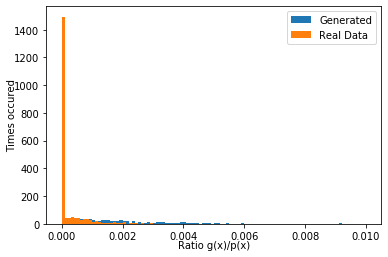

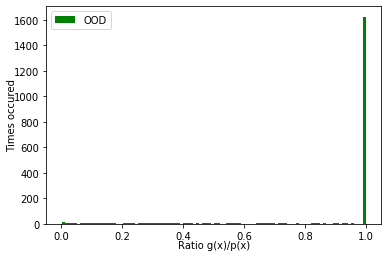

In [9]:
### VISUALIZE OOD

plt.hist(M_G_1[0:2000], range = (0, 0.01), bins=100, label='Generated')
plt.hist(M_F_1[0:2000], range = (0, 0.01), bins=100, label='Real Data')
plt.legend()
plt.tick_params(labelsize=10)
plt.xlabel('Ratio g(x)/p(x)', fontsize=10, labelpad=-1)
plt.ylabel('Times occured', fontsize=10, labelpad=-3)
plt.show()

plt.hist(M_D_1[0:2000], bins=100, label='OOD', color='green',zorder=1)
# plt.hist(M_G_1.detach().cpu().numpy(), range = (0, 0.01), bins=200, label='Generated',zorder=100)
# plt.hist(M_D_1.detach().cpu().numpy(), range = (0, 0.01), bins=200, label='Real Data',zorder=10)

plt.legend()
plt.tick_params(labelsize=10)
plt.xlabel('Ratio g(x)/p(x)', fontsize=10, labelpad=-1)
plt.ylabel('Times occured', fontsize=10, labelpad=-3)
plt.show()

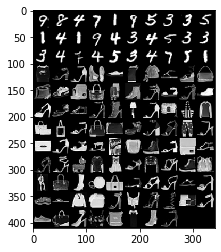

In [12]:
### VISUALIZE FP/FN

import torchvision.utils as vutils

input = new_dataset
input_F = new_dataset_F

#M_F_1 = M_F_1.detach().cpu().numpy()
F_argsort = np.argsort(M_F_1.reshape(-1))
F_sort = input_F[F_argsort]

#input = torch.from_numpy(x).float().cuda()
argsort = np.argsort(M_D_1.reshape(-1))
MD_sort = input[argsort]

G_argsort = np.argsort(M_G_1.reshape(-1))
MG_sort = x_generated[G_argsort]

argsort = np.where(M_D_1.reshape(-1)<1e-2)[0]
MD_sort = input[argsort]

F_argsort = np.where(M_F_1.reshape(-1)>1e-2)[0]
F_sort = input_F[F_argsort]

vutils.save_image(torch.cat((MD_sort, F_sort), 0).data, './FPTP.png', nrow=10, normalize=True)
img = plt.imread('FPTP.png')
plt.imshow(img)
plt.show()